In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sns
from itertools import product
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
import umap.umap_ as umap
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
import GEOparse

# data cleaning (could be improved)

In [2]:
geo_expr = pd.read_csv("GSE209998_AUR_129_UQN.txt.gz",sep='\t')
gse = GEOparse.get_GEO(geo="GSE209998", destdir="./")


21-Mar-2024 13:38:43 DEBUG utils - Directory ./ already exists. Skipping.
21-Mar-2024 13:38:43 INFO GEOparse - File already exist: using local version.
21-Mar-2024 13:38:43 INFO GEOparse - Parsing ./GSE209998_family.soft.gz: 
21-Mar-2024 13:38:43 DEBUG GEOparse - DATABASE: GeoMiame
21-Mar-2024 13:38:43 DEBUG GEOparse - SERIES: GSE209998
21-Mar-2024 13:38:43 DEBUG GEOparse - PLATFORM: GPL16791
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412478
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412479
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412480
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412481
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412482
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412483
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412484
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412485
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412486
21-Mar-2024 13:38:43 DEBUG GEOparse - SAMPLE: GSM6412487
21-Mar-2024 13:38:43 DEBUG GEOpars

In [3]:
geo_expr = geo_expr.set_index('Unnamed: 0')
geo_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
DDX11L1,226.295552,9.364527,81.828101,1.732418e+02,55.411001,70.594612,189.713027,71.952983,129.128416,106.350359,...,5.423877,1.080000e-08,16.470347,13.339344,180.028771,24.464645,18.898216,0.000000,20.889980,0.029141
WASH7P,278.062337,458.132967,920.758358,1.410917e+03,1099.043609,511.626830,2557.589429,1384.932636,1178.785410,1077.756317,...,1035.572218,1.718968e+03,1022.557983,879.090069,3590.402236,1186.907358,1091.301708,351.168479,602.536170,881.767243
MIR6859-3,0.000000,0.243191,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-34P13.3,0.000000,0.996507,2.524623,0.000000e+00,4.986191,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.921808e+00,0.000000,0.000000,0.000000,1.761520,0.000000,0.000000,0.000000,0.000000
MIR1302-9,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,1558.240459,1768.481325,23444.715010,1.110826e+06,107176.339900,4980.868489,28034.970640,4739.375568,9587.406146,5090.115751,...,1264.980886,1.287495e+03,472.285504,2460.446112,3787.626875,8834.800789,3035.175840,2962.858772,2046.919853,2698.422044
MT-TE,0.000000,1.945524,12.958967,3.518182e+01,8.737356,2.040537,10.678057,12.578027,1.915198,28.451139,...,0.000000,0.000000e+00,0.000000,22.336764,2.061855,9.911893,5.393519,4.285717,3.225206,0.000000
MT-CYB,30424.909610,50881.775800,98926.377670,2.247651e+06,273394.925900,69023.398820,263486.385500,26800.002980,88531.957210,84519.282440,...,46556.853130,3.191926e+04,14174.108370,20379.719920,16008.239010,88979.065090,40603.759280,101565.055900,46191.397220,53846.878370


In [4]:
geo_clin_matrix= gse.phenotype_data.copy()

geo_clin_matrix['sample_id'] = [tit.split(' ')[-1][1:-1] for tit in geo_clin_matrix.title]
geo_clin_matrix['patient_id'] = [pat.split('-')[1] for pat in geo_clin_matrix.sample_id]

In [5]:
#geo_clin_matrix.to_csv('AURORA_dataset_clinical_matrix.csv')

In [6]:
common_samps=geo_expr.columns.intersection(geo_clin_matrix['sample_id'])
geo_expr = geo_expr[common_samps]
geo_clin_matrix = geo_clin_matrix[geo_clin_matrix.sample_id.isin(common_samps)]

In [7]:

geo_clin_matrix['characteristics_ch1.0.disease'].value_counts()


Metastatic tumor    79
Primary tumor       44
Normal tissue        6
Name: characteristics_ch1.0.disease, dtype: int64

In [8]:
geo_clin_matrix.iloc[:,10:21]

,characteristics_ch1.0.disease,characteristics_ch1.1.tissue,characteristics_ch1.2.genotype,characteristics_ch1.3.treatment,characteristics_ch1.4.time,treatment_protocol_ch1,growth_protocol_ch1,molecule_ch1,extract_protocol_ch1,description,data_processing
GSM6412478,Primary tumor,Breast,Female,Pre-treatment,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"FFPE,AUR-AFEA-TTP1-A-1-0-R-A741-41",Quality-control-passed reads were aligned to t...
GSM6412479,Metastatic tumor,Lymph node,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM4-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412480,Metastatic tumor,Brain,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM2-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412481,Metastatic tumor,Brain,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412482,Metastatic tumor,Lung,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM3-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
...,...,...,...,...,...,...,...,...,...,...,...
GSM6412602,Normal tissue,Brain,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE9-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412603,Normal tissue,Lung,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE6-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412604,Normal tissue,Liver,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE4-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412605,Normal tissue,Breast,Female,Normal tissue,Non-Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AE5G-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...


In [9]:
met_pat = geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['patient_id'].values
primtum_pat = geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['patient_id'].values

In [10]:
common_pat = pd.Index(met_pat).intersection(primtum_pat)


In [11]:
geo_clin_matrix[geo_clin_matrix['patient_id'].isin(common_pat)]['characteristics_ch1.3.treatment'].value_counts()


Metastasis        63
Pre-treatment     23
Post-treatment    15
Normal tissue      6
Unknown            1
Name: characteristics_ch1.3.treatment, dtype: int64

In [12]:
#liver has two different normal tissue samples. check dates probably remove duplicates
geo_clin_matrix[geo_clin_matrix.columns[geo_clin_matrix.columns.str.contains("characteristics")]]


,characteristics_ch1.0.disease,characteristics_ch1.1.tissue,characteristics_ch1.2.genotype,characteristics_ch1.3.treatment,characteristics_ch1.4.time
GSM6412478,Primary tumor,Breast,Female,Pre-treatment,Autopsy
GSM6412479,Metastatic tumor,Lymph node,Female,Metastasis,Autopsy
GSM6412480,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412481,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412482,Metastatic tumor,Lung,Female,Metastasis,Autopsy
...,...,...,...,...,...
GSM6412602,Normal tissue,Brain,Female,Normal tissue,Autopsy
GSM6412603,Normal tissue,Lung,Female,Normal tissue,Autopsy
GSM6412604,Normal tissue,Liver,Female,Normal tissue,Autopsy
GSM6412605,Normal tissue,Breast,Female,Normal tissue,Non-Autopsy


In [13]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['patient_id'].value_counts()

AE5G    1
AG0M    1
AFKD    1
AFUL    1
AG0J    1
AD9G    1
AFSP    1
AG0N    1
AFUO    1
AG12    1
AF94    1
AFEC    1
AFUI    1
AFR4    1
AFE7    1
AEPZ    1
AFKF    1
AE5H    1
AF98    1
AERX    1
AFR3    1
AF95    1
AFE9    1
AF9A    1
AD9J    1
AER8    1
AFE6    1
AFE5    1
AFSO    1
AFEA    1
AFE4    1
AERW    1
AFUM    1
AER6    1
AER7    1
AFKB    1
AFR5    1
AE6Y    1
AFSL    1
AER4    1
AFR2    1
AER2    1
AFUN    1
AE6X    1
Name: patient_id, dtype: int64

In [14]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['patient_id'].value_counts()

AER6    8
AFEA    5
AFE9    4
AD9H    3
AFEC    3
AD9F    3
AFE7    3
AD9E    3
AFE4    3
AER2    2
AD9G    2
AFUK    2
AFE5    2
AFE6    2
AF94    1
AG12    1
AFR4    1
AG0N    1
AFUI    1
AE5G    1
AFUG    1
AEPZ    1
AFKF    1
ADCB    1
AE5H    1
AF98    1
AERX    1
AFR3    1
AFSP    1
AF9A    1
AG0J    1
AFUL    1
AER8    1
AFSO    1
AERW    1
AFUM    1
AERY    1
AFUP    1
AFKB    1
AFR5    1
AE6Y    1
AFSL    1
AD9I    1
AFUN    1
AER7    1
AG0M    1
AF95    1
AE6X    1
Name: patient_id, dtype: int64

In [15]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['characteristics_ch1.1.tissue'].value_counts()


Liver          18
Lymph node     11
Brain           9
Lung            8
Chest           7
Soft tissue     4
Skin            3
Ovary           3
Pleura          3
Adrenal         3
Bone            2
Peritoneum      1
Thyroid         1
Stomach         1
Uterus          1
Pericardium     1
Rectum          1
Diaphragm       1
Spleen          1
Name: characteristics_ch1.1.tissue, dtype: int64

In [16]:
unwanted_itg=['ITGB3BP','ITGB1BP1','ITGA9-AS1','ITGB5-AS1','ITGB1P1','ITGB2-AS1','ITGB1BP2']
geo_expr=geo_expr.loc[~geo_expr.index.isin(unwanted_itg)]
itg_expr = geo_expr.loc[geo_expr.index.str.contains('ITG')]
itg_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ITGA10,526.184054,532.100428,1071.274167,1271.570476,1096.538609,506.054206,1110.518153,817.572033,1187.422980,601.354404,...,437.577404,473.691646,350.334314,342.783625,548.452701,360.132119,1573.559702,284.285871,604.188335,865.625992
ITGB6,1117.205454,2977.621990,3038.881393,3714.196467,4486.631845,3532.161680,1324.080160,1236.420018,762.249082,435.820295,...,857.790397,3695.745769,1829.274950,3067.866508,0.000000,8.810572,2437.864971,10.000005,10546.422590,6334.380583
ITGA6,5234.329963,7648.563655,11939.139490,10421.342150,9111.394211,6956.973478,54260.822130,154421.090900,93665.113860,53207.021740,...,6088.671462,7408.396466,8736.370876,7663.139329,1365.175365,4687.819418,4133.613363,1598.436993,18794.201230,16912.473680
ITGA4,2543.639052,709.143511,1015.119853,623.221157,1563.985886,6782.750760,1089.161532,1347.107087,944.193745,603.939875,...,388.958198,406.427231,2893.580233,4024.911153,43.298884,134.361472,2537.649967,650.000657,1671.731266,1182.812996
ITGAV,6384.779426,8354.222451,19922.910950,11200.281860,16038.556420,9590.138368,22124.357100,45612.431140,28540.026170,15266.626890,...,11017.357410,12038.078050,11174.245240,24672.542720,5580.371891,16656.758300,11719.032920,4174.903882,9197.921477,18262.409420
ITGA9,3077.303897,2244.747801,1510.554593,3573.031929,2834.876642,3223.091175,4268.550187,5045.051985,3797.761168,2760.498309,...,4115.070336,1656.976467,3757.136394,2250.822548,1470.102320,1110.918049,5500.753062,3062.332899,2818.553013,3149.801994
ITGB5,2349.126338,3873.538215,3846.646436,6624.237560,3709.008214,1281.458503,7365.190256,11111.426540,5963.921073,3588.725977,...,5692.847977,10666.595650,7117.543608,17422.637110,6967.015162,1731.271847,5802.080203,6361.427656,4381.980902,11623.440730
ITGA1,10719.564430,4823.421850,2893.629841,1672.505760,8000.447789,9551.699407,6717.067272,6401.228823,3925.167533,3467.946843,...,9850.667227,7424.163368,7681.185692,6791.593725,258.231885,1928.480691,21788.797450,23190.206680,8996.654725,13502.024050
ITGA2,2251.868248,1928.991238,3330.465298,1120.789993,5355.999200,3870.898262,6735.188468,6017.334094,4814.810475,4346.563070,...,3125.552366,3475.949966,2426.835403,5966.496955,321.649109,4213.652620,3206.443219,207.142971,7920.027754,7268.754986


# other stuff (MAKE SURE to load all cells from above once)

# first checking primary tumor (post-treatment) vs metastatic tumor

In [17]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']!='Pre-treatment'].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [31]:
temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor']['characteristics_ch1.1.tissue'].value_counts()

Liver          18
Lymph node     11
Brain           9
Lung            8
Chest           7
Soft tissue     4
Skin            3
Ovary           3
Pleura          3
Adrenal         3
Bone            2
Peritoneum      1
Thyroid         1
Stomach         1
Uterus          1
Pericardium     1
Rectum          1
Diaphragm       1
Spleen          1
Name: characteristics_ch1.1.tissue, dtype: int64

In [ ]:
#looking at some correlations
#only primary tumor samples
primtum_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[primtum_temp_info_sample['sample_id']].T,
                                                          rowvar=False),
                                          columns=geo_expr[primtum_temp_info_sample['sample_id']].T.columns,
                                              index=geo_expr[primtum_temp_info_sample['sample_id']].T.columns)
#only metastatic tumor samples
met_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[met_temp_info_sample['sample_id']].T,
                                                          rowvar=False),
                                          columns=geo_expr[met_temp_info_sample['sample_id']].T.columns,
                                              index=geo_expr[met_temp_info_sample['sample_id']].T.columns)




In [48]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

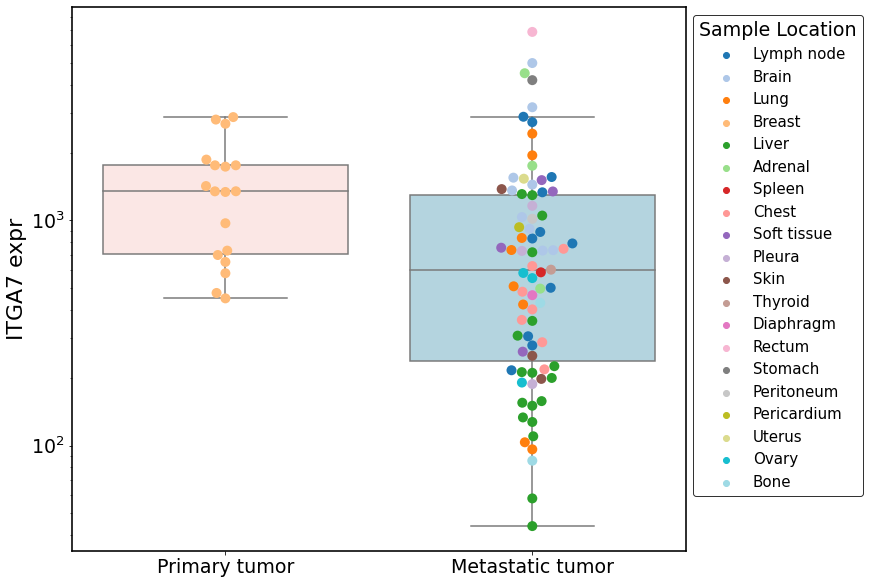

In [69]:
fig,ax=plt.subplots(figsize=(11,10))

gene_chosen='ITGA7'
sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,order = ['Primary tumor', 'Metastatic tumor'])



sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


CPU times: user 2min 2s, sys: 12.3 s, total: 2min 15s
Wall time: 2min 5s


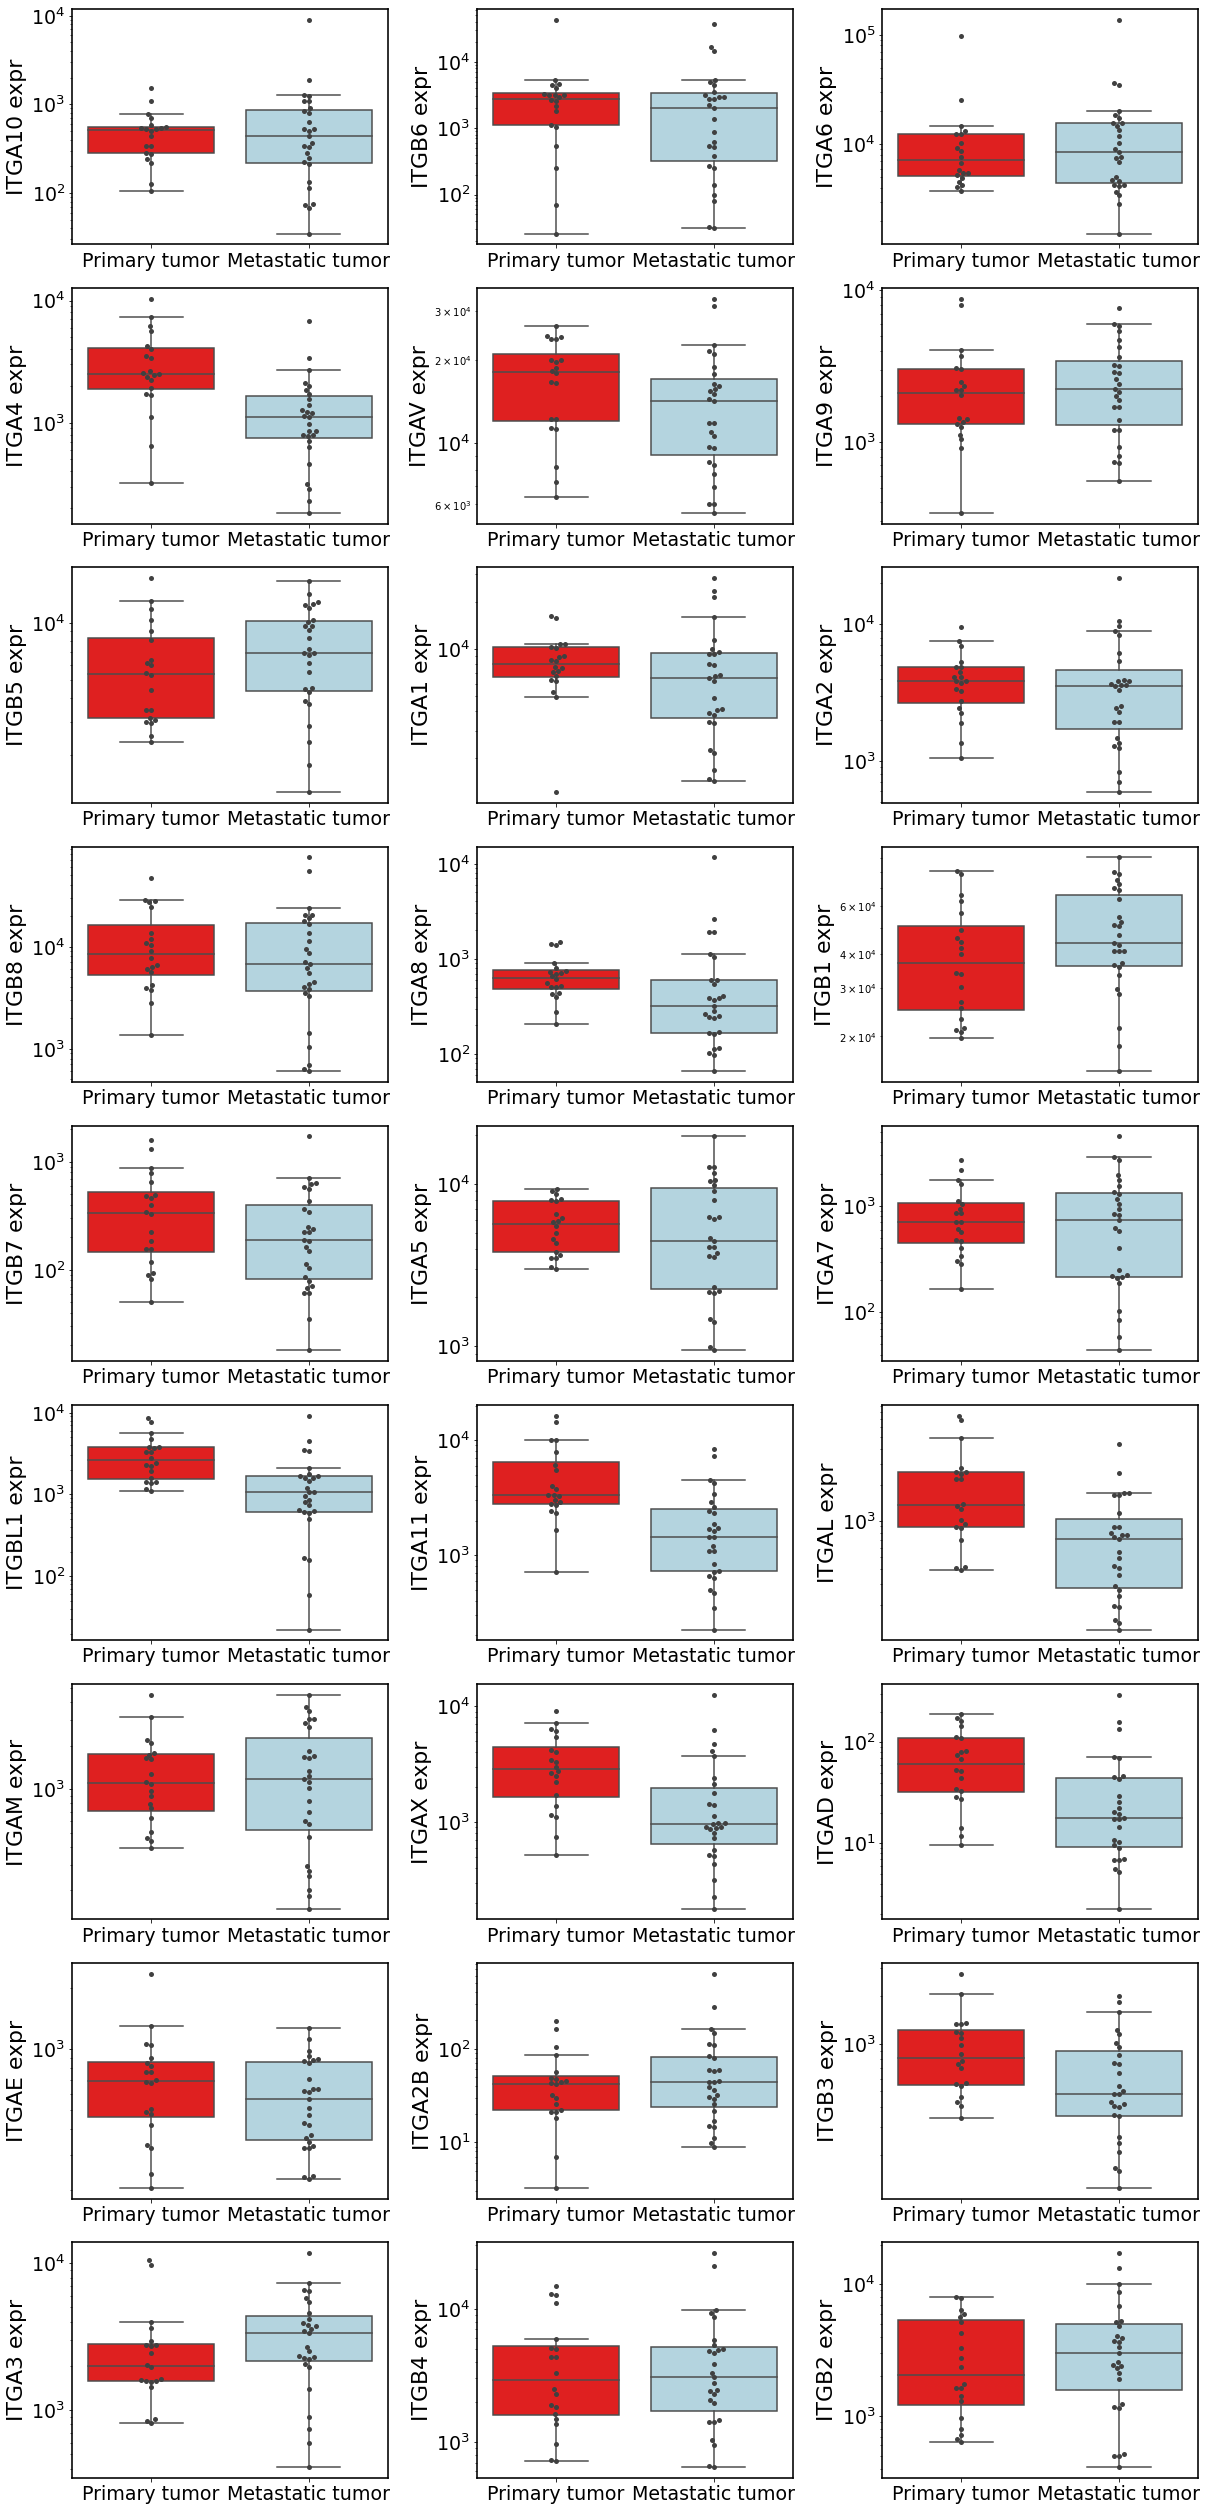

In [16]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [ ]:
#practice for below cell
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,7))


#ylim_min = 0
#ylim_max = 300000
gene_chosen = 'ITGB1'
sns.boxplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='lightblue',
                      ax=ax[0],showfliers=False)
sns.swarmplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='.25',
                      ax=ax[0])

plt.setp(ax[0].get_xticklabels(),fontsize=25)
ax[0].tick_params(axis='y', labelsize=25)      
#ax[0].set_xlabel('Primary Tumor',fontsize=30)
ax[0].set_ylabel(gene_chosen+' Expression',fontsize=30)
ax[0].set_ylim(ylim_min,ylim_max)
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)


sns.boxplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='red',
                       ax=ax[1],showfliers=False)
sns.swarmplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='.25',
                       ax=ax[1])
plt.setp(ax[1].get_xticklabels(),fontsize=25)
ax[1].tick_params(axis='y', labelsize=25)      
ax[1].set_ylim(ylim_min,ylim_max)
#ax[1].set_xlabel('Metastatic Tumor',fontsize=30)
#ax[1].set_ylabel(gene_chosen+' Expression',fontsize=30)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [ ]:
#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#downregulated_missing ='AC010422.5'
#JUST looking at downregulated from the CTC signature list for normoxia vs hypoxia
donato_downregulated = ['TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
nrows = len(donato_downregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,50))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for downreg_gene_prim,downreg_gene_met in zip(donato_downregulated,donato_downregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[downreg_gene_prim].max()
    min_lim=geo_expr.loc[downreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[downreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(downreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[downreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(downreg_gene_met) 
    j+=1
    

plt.tight_layout()



In [ ]:

#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#upregulated_missing ='AC010422.5'
#JUST looking at upregulated from the CTC signature list for normoxia vs hypoxia

donato_upregulated = ['VEGFA','UBALD1','CLCN2','ZNF771','FAM13A','ABCC5','IKZF2','ZBTB43','IRS1',
                       'BIVM','PIK3C2B','LRIG2','MLLT3','PLD6','P4HA1','GDF15','LIPT1','MACC1','PPP1R3E',
                       'EPHX2','POFUT1','NIPAL1','CCNG2','HIF1A','CTSS']

nrows = len(donato_upregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,200))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for upreg_gene_prim,upreg_gene_met in zip(donato_upregulated,donato_upregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[upreg_gene_prim].max()
    min_lim=geo_expr.loc[upreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[upreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(upreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[upreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(upreg_gene_met) 
    j+=1

plt.tight_layout()
    

In [ ]:
donato_upregulated = ['AC010422.5','TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
geo_expr.loc[geo_expr.index[geo_expr.index.isin(donato_upregulated)]].max(axis=1).max()

In [ ]:
pairwise_corr_geo_expr['HIF1A'][pairwise_corr_geo_expr['HIF1A'].index.str.contains('ITG')]

In [ ]:

#get varables from previous cells




fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
feat = temp_info_sample['source_name_ch1']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'sample type', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




In [ ]:

#get varables from previous cells

print("ONLY metastasis samples")
fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')][met_temp_info_sample['sample_id']].T
feat = met_temp_info_sample['characteristics_ch1.1.tissue']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'metastasized to', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
#WARNING careful the features variable here is different than the feat variable in T-sne subsection
features = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
#print("ALL integrins")
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1], hue = temp_info_sample['source_name_ch1'].tolist())
                #hue_order=cancers)
ax.legend(title = 'Cancers', fontsize=20, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_UMAP.jpg', dpi = 1000, bbox_inches='tight')

plt.show()

In [ ]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, distinguishing primary and metastasis sample')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
    y = temp_info_sample['source_name_ch1']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


In [ ]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, on only metastasis samples, met sites')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    y = met_temp_info_sample['characteristics_ch1.1.tissue']
    X = geo_expr[met_temp_info_sample['sample_id']].loc[itg_expr.index].T
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


In [ ]:
corr_cutoff=0.5
met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]


In [ ]:
corr_cutoff=0.5
primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]
